## Section 1: Setting up our Google Colab Environment
---
Before running any code we first need to install MAST-ML as well as it's dependencies into the colab environment.


In [ ]:
!pip install mastml

  Using cached mastml-3.1.8-py3-none-any.whl (1.1 MB)
  Using cached mdf_toolbox-0.6.0-py2.py3-none-any.whl (35 kB)
  Using cached jsonschema-4.3.0-py3-none-any.whl (71 kB)
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.20.0
    Uninstalling jsonschema-4.20.0:
      Successfully uninstalled jsonschema-4.20.0
  Attempting uninstall: mdf-toolbox
    Found existing installation: mdf-toolbox 0.5.11
    Uninstalling mdf-toolbox-0.5.11:
      Successfully uninstalled mdf-toolbox-0.5.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
# !pip install pyyaml==5.4.1

Now we'll sync Colab with our google drive so that we can save directly our outputs to google drive. Make a folder in google drive titled "MASTML_colab" or something similar to direct all your results.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Here we import the MAST-ML modules used.

In [ ]:
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.data_cleaning import DataCleaning
from mastml.preprocessing import SklearnPreprocessor
from mastml.models import SklearnModel
from mastml.data_splitters import SklearnDataSplitter, NoSplit
from mastml.feature_selectors import EnsembleModelFeatureSelector, NoSelect
from mastml.feature_generators import ElementalFeatureGenerator
from mastml.hyper_opt import GridSearch

Remember if you are seeing import errrors it might be because you haven't restarted the runtime after installing the packages.

And finally we'll import pandas to help with handling dataframes throughout the notebook.

In [ ]:
import pandas as pd

## Section 2: Data Cleaning


---
Read in player data, perform some cleaning, and create cleaned dataset


In [ ]:
df = pd.read_csv("./drive/MyDrive/MASTML_colab/2022-2023_NBA_Player_Stats-Regular.csv", sep = ';', encoding='ISO-8859-1')

In [ ]:
df

In [ ]:
df.shape

(679, 30)

In [ ]:
import matplotlib.pyplot as plt
import random
import math

Plotting the histogram of player positions before cleaning

Text(0, 0.5, 'Frequency')

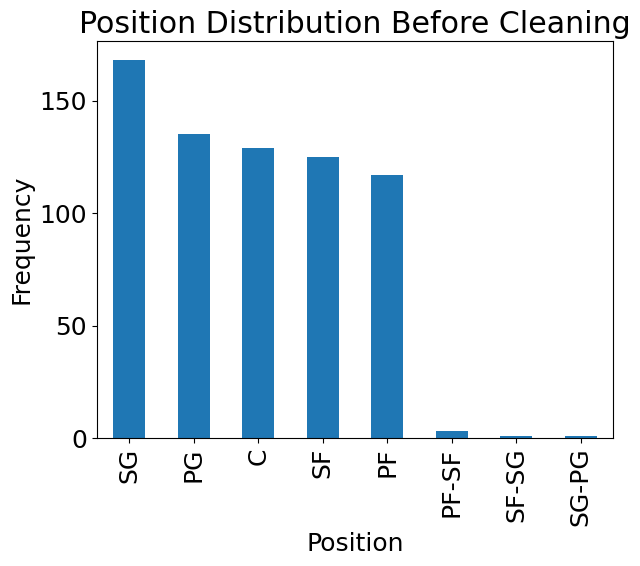

In [ ]:
pos_frequency_before = df['Pos'].value_counts()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
pos_frequency_before.plot(kind='bar')
plt.title('Position Distribution Before Cleaning')
plt.xlabel('Position')
plt.ylabel('Frequency')

Cleaning dataset:

*   Dropping features with poor correlation with player positions
*   For players occupying more than one row entry as a result of playing for multiple teams in the regular season, only the row with the total stats for the season is used.
*   For players that play in more than one position, only the first mentioned
*   To prepare the Pos (position) feature for classification, each position was converted to a distinct integer value.




In [ ]:
df_clean = df.drop(columns=['G', 'GS', 'MP', 'TOV', 'Rk', 'PTS', 'PF', 'eFG%', 'FT', 'FTA', 'FT%'])
df_clean = df_clean.drop_duplicates(subset='Player', keep='first')
df_clean['Pos'] = df_clean['Pos'].apply(lambda x: x[:2] if len(x) > 2 else x)
df_clean['Pos'] = df_clean['Pos'].map({'PG': 1, 'SG': 2, 'SF': 3, 'PF': 4, 'C': 5})
df_clean = df_clean.sort_values('Pos').reset_index(drop=True)

In [ ]:
df_clean

,Player,Pos,Age,Tm,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,ORB,DRB,TRB,AST,STL,BLK
0,Bones Hyland,1,22,TOT,4.1,10.2,0.399,2.1,5.6,0.371,2.0,4.6,0.434,0.4,2.1,2.4,3.1,0.7,0.3
1,Devonte' Graham,1,27,TOT,2.2,5.9,0.374,1.6,4.6,0.352,0.6,1.3,0.452,0.3,1.4,1.7,2.7,0.6,0.2
2,Tyrese Haliburton,1,22,IND,7.4,15.0,0.490,2.9,7.2,0.400,4.5,7.8,0.572,0.6,3.1,3.7,10.4,1.6,0.4
3,R.J. Hampton,1,21,TOT,2.2,5.0,0.430,0.9,2.5,0.353,1.3,2.6,0.504,0.4,1.5,1.9,1.1,0.6,0.2
4,James Harden,1,33,PHI,6.4,14.5,0.441,2.8,7.2,0.385,3.6,7.3,0.495,0.7,5.4,6.1,10.7,1.2,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,Robin Lopez,5,34,CLE,1.3,2.0,0.640,0.1,0.1,0.500,1.2,1.9,0.648,0.6,0.8,1.4,0.5,0.1,0.2
535,Sandro Mamukelashvili,5,23,TOT,2.3,5.3,0.422,0.7,2.3,0.303,1.6,3.0,0.511,1.6,2.7,4.3,1.4,0.3,0.3
536,Boban Marjanovi?,5,34,HOU,1.3,1.9,0.683,0.0,0.0,0.000,1.3,1.9,0.695,0.6,1.3,1.9,0.3,0.2,0.1
537,Jericho Sims,5,24,NYK,1.6,2.1,0.776,0.0,0.0,0.000,1.6,2.0,0.783,1.9,2.8,4.7,0.5,0.3,0.5


In [ ]:
indices = df_clean.drop_duplicates(subset='Pos', keep='first').index
indices

Int64Index([0, 102, 241, 339, 438], dtype='int64')

Plotting the histogram of player positions after cleaning

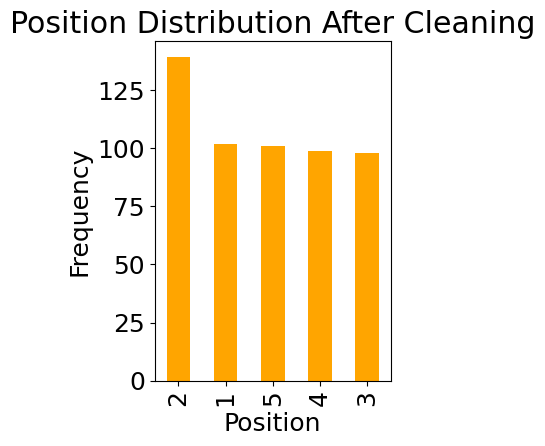

In [ ]:
pos_frequency_after = df_clean['Pos'].value_counts()

plt.subplot(1, 2, 2)
pos_frequency_after.plot(kind='bar', color='orange')
plt.title('Position Distribution After Cleaning')
plt.xlabel('Position')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
n = math.ceil(df_clean.shape[0]/25)
test_indices = []
test_indices.extend(random.sample(range(0, indices[1]), n))
test_indices.extend(random.sample(range(indices[1], indices[2]), n))
test_indices.extend(random.sample(range(indices[2], indices[3]), n))
test_indices.extend(random.sample(range(indices[3], indices[4]), n))
test_indices.extend(random.sample(range(indices[4], df_clean.shape[0]), n))
test_indices

[28,
 97,
 55,
 43,
 50,
 53,
 9,
 33,
 74,
 15,
 30,
 81,
 84,
 31,
 64,
 61,
 60,
 54,
 16,
 23,
 96,
 70,
 201,
 237,
 151,
 110,
 225,
 193,
 177,
 143,
 154,
 111,
 185,
 146,
 206,
 144,
 194,
 187,
 208,
 104,
 136,
 240,
 176,
 150,
 308,
 302,
 270,
 330,
 241,
 335,
 269,
 323,
 303,
 315,
 260,
 313,
 327,
 288,
 250,
 321,
 301,
 325,
 273,
 314,
 312,
 309,
 387,
 367,
 353,
 377,
 433,
 381,
 403,
 378,
 364,
 398,
 405,
 369,
 385,
 410,
 379,
 382,
 357,
 343,
 368,
 421,
 341,
 420,
 483,
 476,
 464,
 470,
 478,
 443,
 517,
 475,
 532,
 438,
 521,
 512,
 537,
 526,
 444,
 477,
 488,
 494,
 480,
 534,
 458,
 469]

Finally we define a new column "testdata" which is going to be a binary column that is either 0 for "not testing data" or 1 for "is testing data". This is what we can feed into MAST-ML to explicitly define a set of Test data that is held out from all training.

In [ ]:
df_clean["testdata"]=0

In [ ]:
for idx in test_indices:
  df_clean.at[idx,'testdata']=1

And with that setup we'll save a new version of the dataset just to keep track of changes as we go.

In [ ]:
output_path = "./drive/MyDrive/MASTML_colab/2022-2023_NBA_Player_Stats-Regular_v2.csv"
df_clean.to_csv(output_path,index=False)

In [ ]:
columns_list = df_clean.columns.tolist()
columns_list.remove('Player')
columns_list.remove('Tm')
columns_list.remove('testdata')

In [ ]:
columns_list

['Pos',
 'Age',
 'G',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK']

## Section 3: Initializing MAST-ML
---
Now we'll dive into interacting more directly with the MAST-ML software. The first thing we need to do is setup some of the baseline information that MASTML will use as we call different sections of the code. This is similar to the [general] section from the previous configuration file oriented code base.


Set the name of the savepath to save MAST-ML results to. It's recommended to make this a unique name each time you come back to this notebook. That way all the outputs you get from each session will be in a unique location that's easier to come back to later.

By default I've set the output to the "nanohub_workflow" folder under our colab folder.

In [ ]:
SAVEPATH = 'drive/MyDrive/MASTML_colab/EndOfSemester_1'

mastml = Mastml(savepath=SAVEPATH)
savepath = mastml.get_savepath

With MAST-ML initialized you should see your output directory created. You can check this using the file tree on the left of the screen or directly through google drive.

Next up we need to define the configuration of our Data file that we setup earlier. We'll define the names for all of the key components:  
target: the target variable that we want to predict  
extra_columns: the metadata columns that aren't features but we still want to keep track off  
testdata_columns: the column with binary values defining what is and isn't test data  
group_column: column names specifying unique groups in the data. We don't use this during this workflow  
as_frame: determines the structure of outputs. True gives us dataframe outputs that are easier to read in the notebook

In [ ]:
feature_names = ['Age', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK']
target = 'Pos'
extra_columns = ['Player', 'Tm']
testdata_columns = ['testdata']

# calling the LocalDatasets section of the code initializes this section which we then execute with the method below
d = LocalDatasets(file_path='./drive/MyDrive/MASTML_colab/2022-2023_NBA_Player_Stats-Regular_v2.csv',
                  feature_names=feature_names,
                  target=target,
                  extra_columns=extra_columns,
                  group_column=None,
                  testdata_columns=testdata_columns,
                  as_frame=True)

# Load the data with the load_data() method
data_dict = d.load_data()

In [ ]:
data_dict.keys()

dict_keys(['X', 'y', 'groups', 'X_extra', 'X_testdata'])

We'll take each of these and assign them to their own object, to use going forwards.

In [ ]:
X = data_dict['X']
y = data_dict['y']
X_extra = data_dict['X_extra']
groups = data_dict['groups']
X_testdata = data_dict['X_testdata']

In [ ]:
X

,Age,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,ORB,DRB,TRB,AST,STL,BLK
0,22,4.1,10.2,0.399,2.1,5.6,0.371,2.0,4.6,0.434,0.4,2.1,2.4,3.1,0.7,0.3
1,27,2.2,5.9,0.374,1.6,4.6,0.352,0.6,1.3,0.452,0.3,1.4,1.7,2.7,0.6,0.2
2,22,7.4,15.0,0.490,2.9,7.2,0.400,4.5,7.8,0.572,0.6,3.1,3.7,10.4,1.6,0.4
3,21,2.2,5.0,0.430,0.9,2.5,0.353,1.3,2.6,0.504,0.4,1.5,1.9,1.1,0.6,0.2
4,33,6.4,14.5,0.441,2.8,7.2,0.385,3.6,7.3,0.495,0.7,5.4,6.1,10.7,1.2,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,34,1.3,2.0,0.640,0.1,0.1,0.500,1.2,1.9,0.648,0.6,0.8,1.4,0.5,0.1,0.2
535,23,2.3,5.3,0.422,0.7,2.3,0.303,1.6,3.0,0.511,1.6,2.7,4.3,1.4,0.3,0.3
536,34,1.3,1.9,0.683,0.0,0.0,0.000,1.3,1.9,0.695,0.6,1.3,1.9,0.3,0.2,0.1
537,24,1.6,2.1,0.776,0.0,0.0,0.000,1.6,2.0,0.783,1.9,2.8,4.7,0.5,0.3,0.5


In [ ]:
groups

In [ ]:
X_extra

,Player,Tm
0,Bones Hyland,TOT
1,Devonte' Graham,TOT
2,Tyrese Haliburton,IND
3,R.J. Hampton,TOT
4,James Harden,PHI
...,...,...
534,Robin Lopez,CLE
535,Sandro Mamukelashvili,TOT
536,Boban Marjanovi?,HOU
537,Jericho Sims,NYK


In [ ]:
X_testdata

[array([  9,  15,  16,  23,  28,  30,  31,  33,  43,  50,  53,  54,  55,
         60,  61,  64,  70,  74,  81,  84,  96,  97, 104, 110, 111, 136,
        143, 144, 146, 150, 151, 154, 176, 177, 185, 187, 193, 194, 201,
        206, 208, 225, 237, 240, 241, 250, 260, 269, 270, 273, 288, 301,
        302, 303, 308, 309, 312, 313, 314, 315, 321, 323, 325, 327, 330,
        335, 341, 343, 353, 357, 364, 367, 368, 369, 377, 378, 379, 381,
        382, 385, 387, 398, 403, 405, 410, 420, 421, 433, 438, 443, 444,
        458, 464, 469, 470, 475, 476, 477, 478, 480, 483, 488, 494, 512,
        517, 521, 526, 532, 534, 537])]

## Section 4: Reproducing Key Workflow Steps
---
1) Feature Engineering  
2) Model Assessment and Training  
3) Model Optimization  
4) Model Predictions  
5) Model Performance Visualization  


If the data contains missing values, we can clean the data with the built in tools in MAST-ML, which corrects missing values and provides some basic analysis of the input data. Since there are no missing values the data cleaner will still output some useful plots and statistics of our input data.

In [ ]:
# cleaner = DataCleaning()
# X, y = cleaner.evaluate(X=X,
#                         y=y,
#                         method='imputation',
#                         strategy='mean',
#                         savepath=savepath)

Filter highly correlated features if necessary

In [ ]:
# features_corr_df = X.corr(method="pearson").abs()
# # Filter the features with correlation coefficients above 0.95
# upper = features_corr_df.where(np.triu(np.ones(features_corr_df.shape), k=1).astype(bool))
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# X = X.drop(columns=to_drop)

In [ ]:
# X

Next up we perform the last feature engineering step, which was to normalize the features using scikit-learn's MinMaxScaler method.

In [ ]:
# preprocessor = SklearnPreprocessor(preprocessor='MinMaxScaler', as_frame=True)
# X = preprocessor.evaluate(X=X,
#                           y=y,
#                           savepath=savepath)

## Section 5: Modifying the Workflow
---

1) building a default model where no change in any hyperparameters from the scikit-learn defaults and analyze it's performance through 5-Fold CV and then directly on the Test dataset.  

2) Perform a grid search on 2 of the hyperparameters.

3) Compare the performance with the optimized hyperparameters through 5-Fold CV.

5) Visualize

Testing defaulting model directly on Test dataset

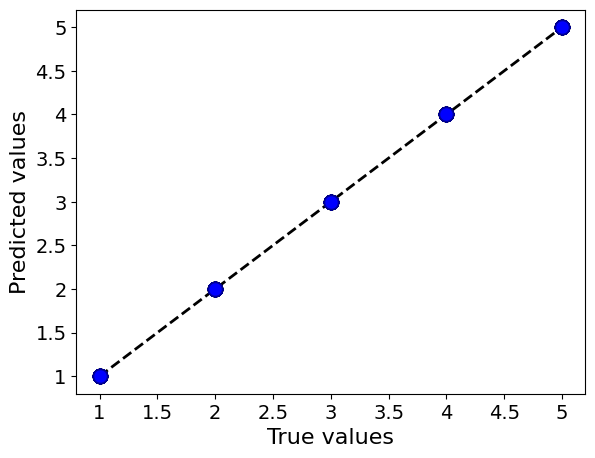

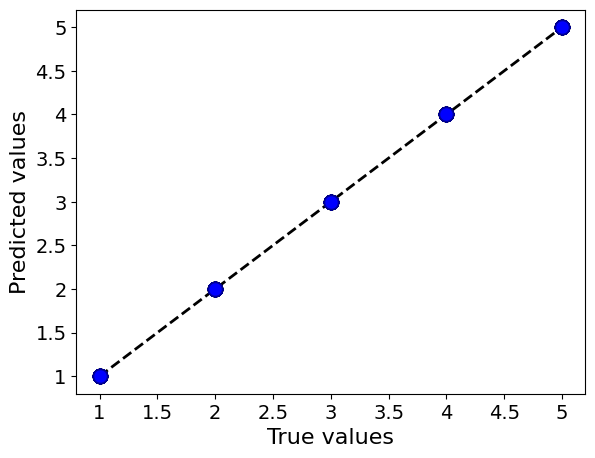

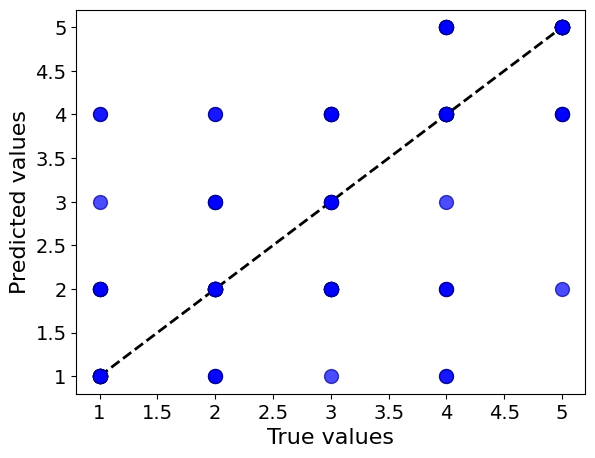

In [ ]:
default_RF = SklearnModel(model='RandomForestClassifier')
models = [default_RF]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

splitter = NoSplit()
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  verbosity=3)

k-Fold Cross Validation before hyperparameter optimization

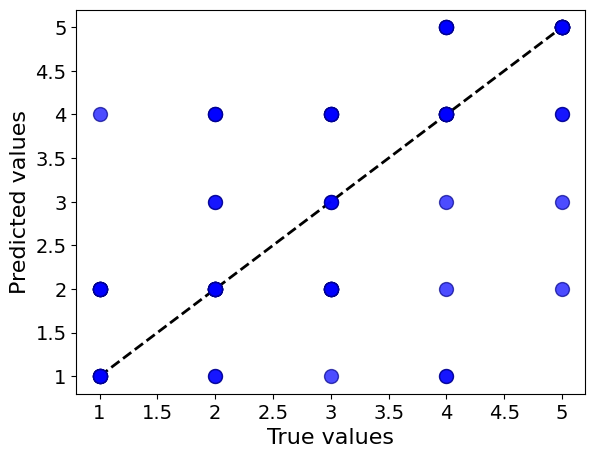

In [ ]:
default_RF = SklearnModel(model='RandomForestClassifier')
models = [default_RF]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=2, n_splits=5)
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  verbosity=3)

Grid Search to optimize n_estimators and max_depth

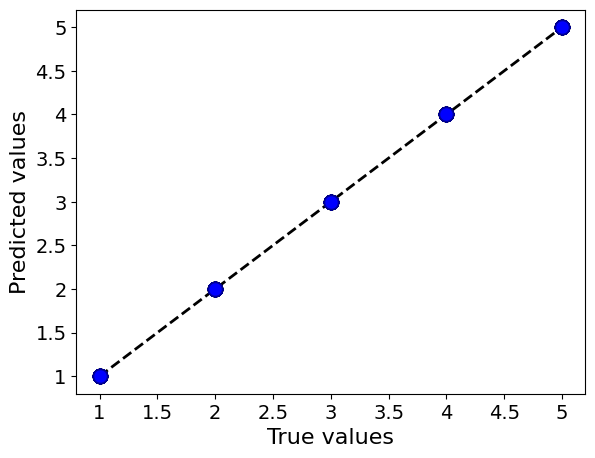

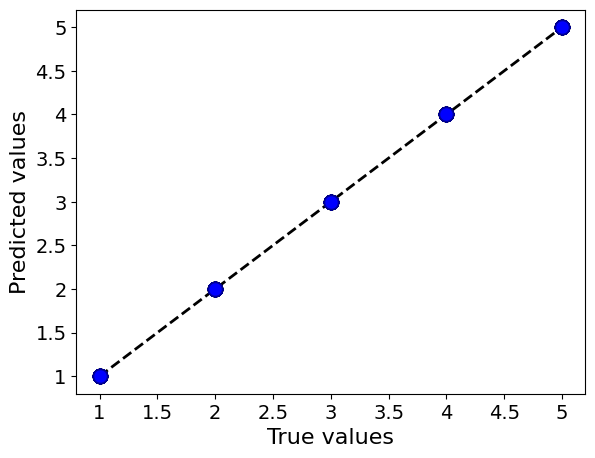

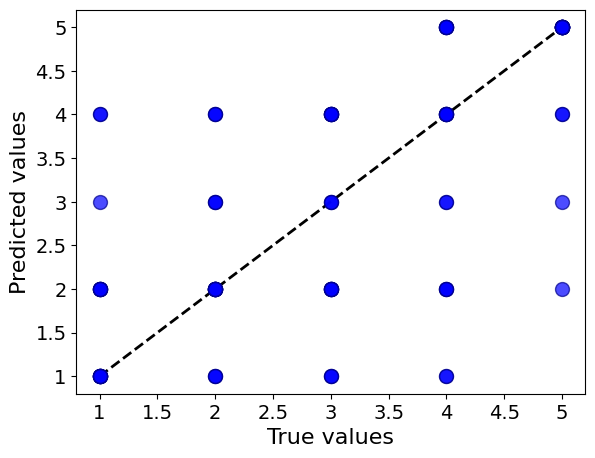

In [ ]:
default_RF = SklearnModel(model='RandomForestClassifier')
models = [default_RF]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']
grid1 = GridSearch(param_names='n_estimators ; max_depth',param_values='10 610 30 lin int ; 1 100 20 lin int',scoring='root_mean_squared_error')
grids = [grid1]
splitter = NoSplit()
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  hyperopts = grids,
                  recalibrate_errors = True,
                  verbosity=3)

Grid Search to optimize max_depth using optimized n_estimators

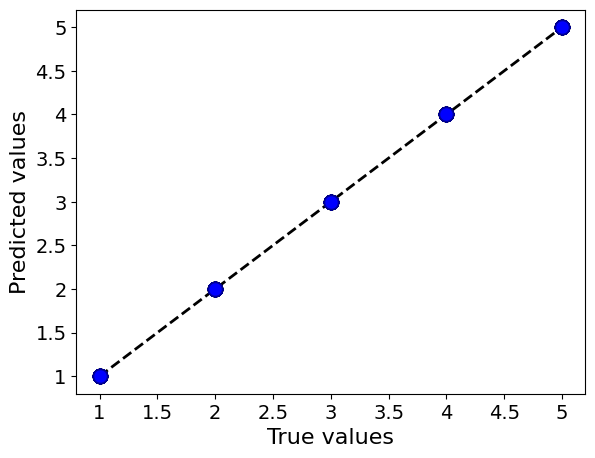

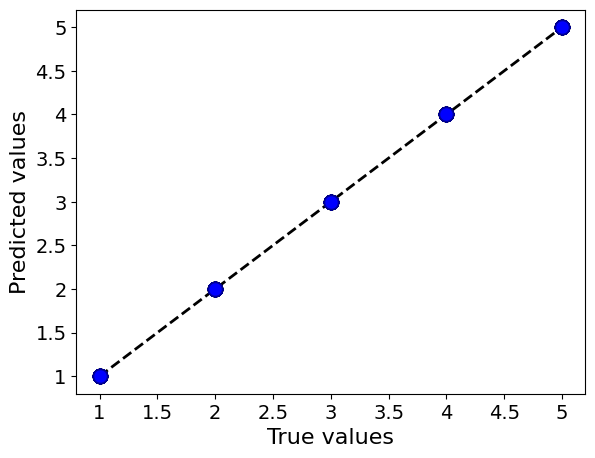

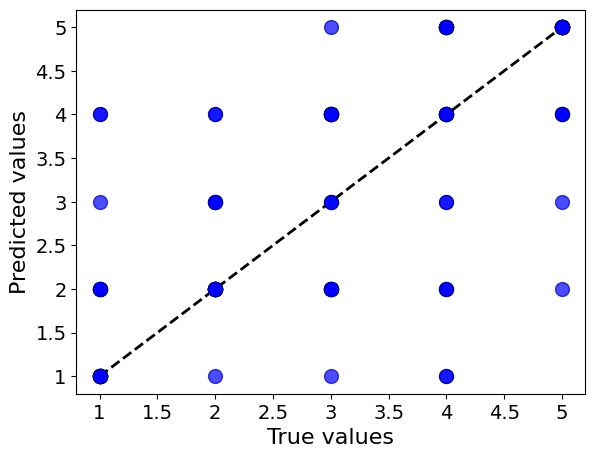

In [ ]:
default_RF = SklearnModel(model='RandomForestClassifier', n_estimators=258)
models = [default_RF]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']
grid1 = GridSearch(param_names='max_depth',param_values='1 100 20 lin int',scoring='root_mean_squared_error')
grids = [grid1]
splitter = NoSplit()
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  hyperopts = grids,
                  recalibrate_errors = True,
                  verbosity=3)

k-Fold Cross Validation after hyperparameter optimization

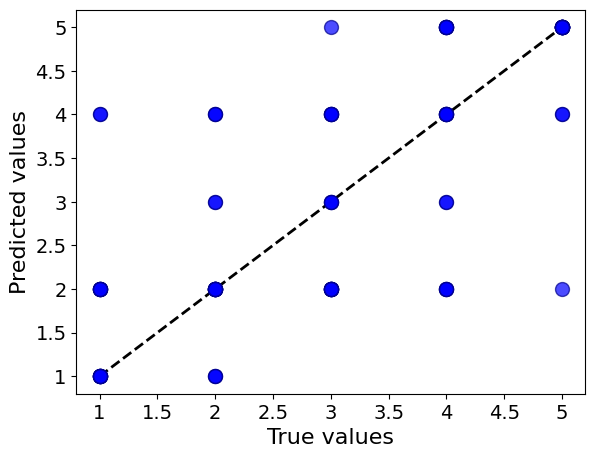

In [ ]:
opt_RF = SklearnModel(model='RandomForestClassifier',n_estimators=258, max_depth=47)
models = [opt_RF]
selector = [NoSelect()]
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=2, n_splits=5)
splitter.evaluate(X=X,
                  y=y,
                  models=models,
                  preprocessor=None,
                  selectors=selector,
                  metrics=metrics,
                  savepath=savepath,
                  X_extra=X_extra,
                  leaveout_inds=X_testdata,
                  recalibrate_errors = True,
                  verbosity=3)

In [ ]:
y_test_before = pd.read_csv("./drive/MyDrive/MASTML_colab/EndOfSemester_1/RandomForestClassifier_RepeatedKFold_NoPreprocessor_NoSelect_2023_12_28_06_47_11/split_outer_0/y_test.csv")
y_pred_before = pd.read_csv("./drive/MyDrive/MASTML_colab/EndOfSemester_1/RandomForestClassifier_RepeatedKFold_NoPreprocessor_NoSelect_2023_12_28_06_47_11/split_outer_0/y_pred.csv")
y_test_after = pd.read_csv("./drive/MyDrive/MASTML_colab/EndOfSemester_1/RandomForestClassifier_RepeatedKFold_NoPreprocessor_NoSelect_2023_12_28_06_44_24/split_outer_0/y_test.csv")
y_pred_after = pd.read_csv("./drive/MyDrive/MASTML_colab/EndOfSemester_1/RandomForestClassifier_RepeatedKFold_NoPreprocessor_NoSelect_2023_12_28_06_44_24/split_outer_0/y_pred.csv")

In [ ]:
# from mastml.metrics import Metrics
import mastml.plots

Accuracy scores before hyperparameter optimization

In [ ]:
print(mastml.plots.classification_report(y_test_before, y_pred_before))

              precision    recall  f1-score   support

           1       0.59      0.51      0.55       160
           2       0.42      0.54      0.47       234
           3       0.34      0.26      0.30       152
           4       0.38      0.36      0.37       154
           5       0.69      0.68      0.69       158

    accuracy                           0.48       858
   macro avg       0.49      0.47      0.48       858
weighted avg       0.48      0.48      0.48       858



Visualization of accuracy scores before hyperparameter optimization

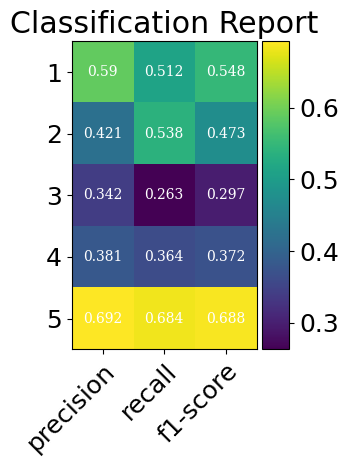

In [ ]:
mastml.plots.Classification().plot_classification_report(y_true=y_test_before, y_pred=y_pred_before, savepath=savepath, data_type='test', show_figure=True)

Accuracy scores after hyperparameter optimization

In [ ]:
print(mastml.plots.classification_report(y_test_after, y_pred_after))

              precision    recall  f1-score   support

           1       0.63      0.56      0.59       160
           2       0.45      0.59      0.51       234
           3       0.39      0.26      0.31       152
           4       0.38      0.34      0.36       154
           5       0.69      0.73      0.71       158

    accuracy                           0.51       858
   macro avg       0.51      0.50      0.50       858
weighted avg       0.50      0.51      0.50       858



Visualization of accuracy scores after hyperparameter optimization

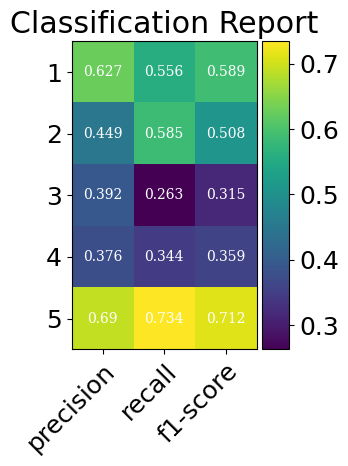

In [ ]:
mastml.plots.Classification().plot_classification_report(y_true=y_test_after, y_pred=y_pred_after, savepath=savepath, data_type='test', show_figure=True)